# Email app report
## by Zhijian Yang

# AI Usage:
1. Help me refine the report and generate charts.
2. Help me write automation scripts for batch experiments.(batch_experiment.py)
3. Refine the prompt (edge ​​cases)
4. Add batch processing into the app

# Executive Summary
This project compared the performance of GPT-4.1 and GPT-4o-mini on different email editing tasks, including elaboration, shortening, and tone adjustment. Each model's output was scored by two independent LLM reviewers, evaluating faithfulness (adherence to the original text) and completeness (whether the content was fully extended or supplemented). In addition to real email data, we also generated some emails containing edge cases using scripts to test the models' stability under different lengths and task objectives. The experimental results showed that GPT-4.1 had a higher and more stable average score in completeness (4.87), while GPT-4o-mini had a slight advantage in faithfulness. Considering all types of tasks, especially the requirement for completeness when content expansion is needed, and given the need for a conservative decision when only one model can be chosen, we ultimately selected GPT-4.1 as the primary model.

# Model Overview:
We are using two different models, both provided by OpenAI: ChatGPT 4.1 and ChatGPT 4o-mini. 

# Method and Performance Metrics:

For each model-generated output, we use two independent LLM reviewers to assign scores, evaluating both faithfulness and completeness. Faithfulness measures whether the output content is strictly supported by the original input, focusing on whether the model introduces facts not mentioned in the original text, causes semantic drift, or alters the original intent. Completeness, on the other hand, measures the model's ability to reasonably continue and expand upon the content given the task, evaluating whether it completes and covers the key information points required by the task, and whether the output forms a complete and coherent text at both the logical and informational levels.

## Benchmarks:

In the prompt for the LLM judge, I set five scores from 1 to 5, instructing the LLM to strictly follow this rule when scoring the output:

### For completeness:
      5 - Fully complete:
          The edited text preserves all critical and non-critical information
          required to complete the intended task, including any essential
          links, references, deadlines, or instructions. No meaningful or
          operational gaps are present.

      4 - Mostly complete:
          The edited text preserves all critical information required to
          complete the task, but omits or underdevelops some secondary,
          contextual, or optional details.

      3 - Moderately complete:
          The edited text addresses the main intent but omits multiple
          important details, constraints, or implied requirements,
          reducing clarity or executability.

      2 - Largely incomplete:
          The edited text covers only part of the main intent and misses
          many key requirements or pieces of critical supporting information.

      1 - Severely incomplete:
          The edited text fails to address the core intent of the original
          message or omits most critical information, making the task
          difficult or impossible to complete.

### For faithfulness:
      5 - Fully faithful:
          All content in the edited text is fully supported by
          the original text or clearly and directly implied.
          No hallucinations or misleading additions are present.

      4 - Mostly faithful:
          The edited text is largely supported by the original text,
          but includes very minor assumptions or elaborations
          that slightly go beyond what is stated.

      3 - Partially faithful:
          The edited text includes several unsupported assumptions,
          extrapolations, or reinterpretations that are not clearly
          grounded in the original text.

      2 - Largely unfaithful:
          The edited text introduces many details or claims
          that are not supported by the original text
          and could misrepresent its intent.

      1 - Severely unfaithful:
          Most or all of the edited text is not grounded
          in the original text and contains significant hallucination.

### Data Stnthesis:
I also wrote a separate Python script to generate test email data containing edge cases, such as embedded image links and special characters in email addresses. This data was also generated by ChatGPT 4.1; in preliminary testing, we found no significant difference in performance between gpt-4.1 and gpt-4o-mini on email generation tasks, so we chose to use gpt-4.1 to generate all input data. The script supports flexible configuration of the generated email length and target task type, such as different editing scenarios like elaborate, shorten, or tone, ensuring controllability and diversity in the structural complexity and task objectives of the evaluation data. For each task, I used the script to generate 25 additional edge cases for model comparison testing.

In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt

LOG_PATH = "/Users/jerry.yang/Desktop/ai_bootcamp/ai_bootcamp_starter/logs/batch_experiments.jsonl"

records = []
with open(LOG_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        r = json.loads(line)
        records.append(r)

df = pd.DataFrame(records)

In [20]:
rows = []

for _, r in df.iterrows():
    for metric in ["faithfulness", "completeness"]:
        rows.append({
            "model": r["model"],
            "operation": r["operation"],
            "metric": metric,
            "score": r[f"{metric}_rating"]
        })

score_df = pd.DataFrame(rows)
print(score_df.head())

         model operation        metric  score
0  gpt-4o-mini   shorten  faithfulness      5
1  gpt-4o-mini   shorten  completeness      5
2  gpt-4o-mini   shorten  faithfulness      5
3  gpt-4o-mini   shorten  completeness      4
4  gpt-4o-mini   shorten  faithfulness      5


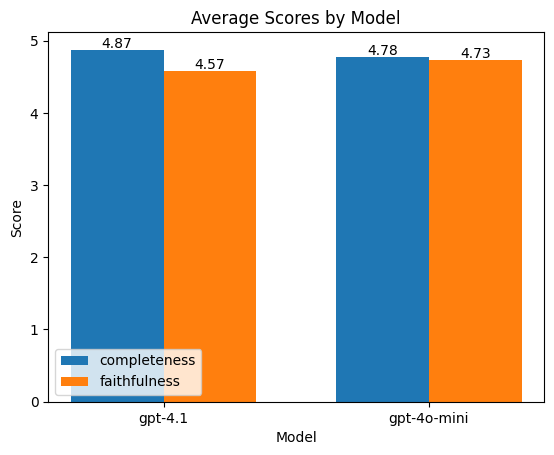

In [21]:
avg_df = (
    score_df
    .groupby(["model", "metric"])["score"]
    .mean()
    .reset_index()
)

models = avg_df["model"].unique()
x = range(len(models))
width = 0.35

comp_scores = [
    avg_df[(avg_df["model"] == m) & (avg_df["metric"] == "completeness")]["score"].values[0]
    for m in models
]
faith_scores = [
    avg_df[(avg_df["model"] == m) & (avg_df["metric"] == "faithfulness")]["score"].values[0]
    for m in models
]

plt.figure()
plt.bar([i - width / 2 for i in x], comp_scores, width, label="completeness")
plt.bar([i + width / 2 for i in x], faith_scores, width, label="faithfulness")

for i, v in enumerate(comp_scores):
    plt.text(i - width / 2, v + 0.03, f"{v:.2f}", ha="center")
for i, v in enumerate(faith_scores):
    plt.text(i + width / 2, v + 0.03, f"{v:.2f}", ha="center")

plt.xticks(x, models)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Average Scores by Model")
plt.legend()
plt.show()


GPT-4.1 achieved a higher average score in completeness (4.87), while GPT-4o-mini had a slight advantage in faithfulness (4.73). This suggests that GPT-4.1 is better at providing comprehensive content continuation and information completion in editing tasks, while GPT-4o-mini tends to maintain stricter fidelity to the original text's semantics. Of course, the influence of the model's preset temperature cannot be ruled out.

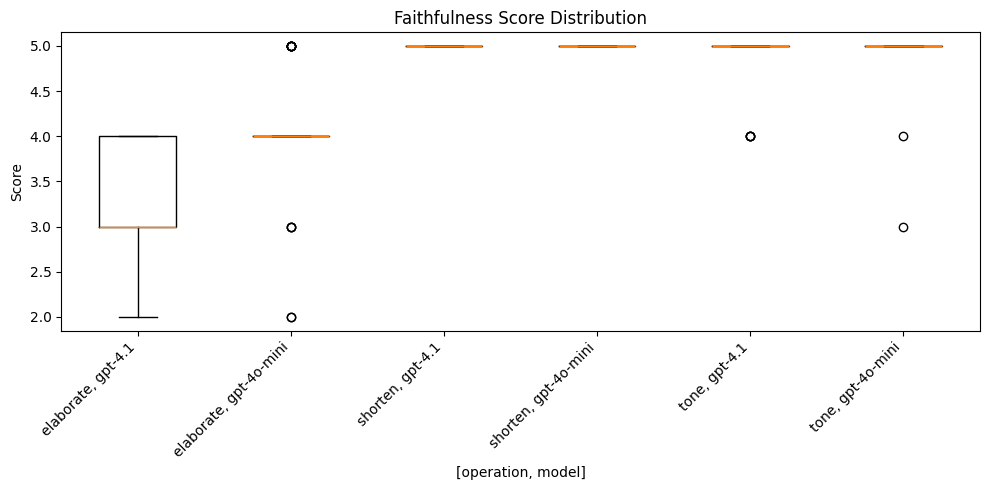

In [25]:
faith_df = score_df[score_df["metric"] == "faithfulness"].copy()
faith_df["group"] = faith_df["operation"] + ", " + faith_df["model"]

groups = []
labels = []

for name, g in faith_df.groupby("group"):
    groups.append(g["score"].values)
    labels.append(name)

plt.figure(figsize=(10, 5))
plt.boxplot(groups, tick_labels=labels)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.xlabel("[operation, model]")
plt.title("Faithfulness Score Distribution")
plt.tight_layout()
plt.show()


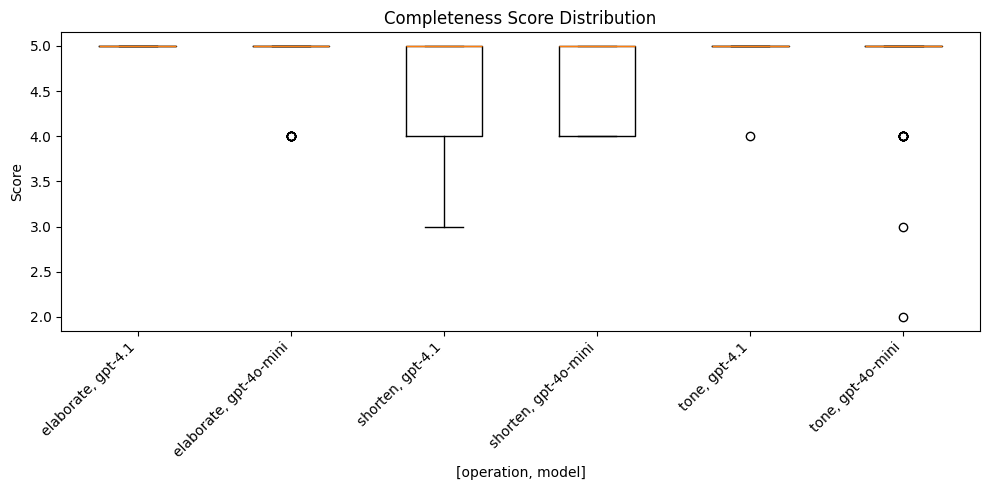

In [24]:
comp_df = score_df[score_df["metric"] == "completeness"].copy()
comp_df["group"] = comp_df["operation"] + ", " + comp_df["model"]

groups = []
labels = []

for name, g in comp_df.groupby("group"):
    groups.append(g["score"].values)
    labels.append(name)

plt.figure(figsize=(10, 5))
plt.boxplot(groups, tick_labels=labels)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.xlabel("[operation, model]")
plt.title("Completeness Score Distribution")
plt.tight_layout()
plt.show()


In the faithfulness distribution analysis, the main differences between the models were observed in the elaborate task. GPT-4.1 showed a more dispersed score distribution in this task, with scores as low as 2, indicating that when more content expansion is required, the model is more likely to introduce information not explicitly supported by the original text. In contrast, GPT-4o-mini's scores were more concentrated in the 4–5 range, demonstrating more stable and conservative rewriting behavior. In the other two actions, the models' performance was mostly concentrated at 5, meaning both models performed well in these two actions, with no significant differences between them.

In all editing operations, integrity is generally well-maintained. However, while the tasks of elaborating and shortening text consistently show high integrity in both models, tone editing reveals some differences. The GPT-4o-mini results showed some outliers, meaning some results exhibited extreme values, such as scores of 2 or 3. These may be isolated incidents and require further analysis.

Ideally, we should use different models for different tasks, but if we can only choose one model, based on our experimental data, I would choose ChatGPT 4o-mini. This is because, for email-related tasks, faithfulness is considered a more important metric, as introducing information not present in the original text is more unacceptable (L1 error). A lower completeness score, on the other hand, might simply mean that some information deemed secondary by the LLM was omitted, which is acceptable.

# Usecases and Applications
### Action: elaborate

### Input email:
"Hi team,\n\nCould someone review the Q3 Sales Presentation and update the figures for the NorthStar product line? Please make sure it's ready before our meeting on June 15. The current deck is still on the Google Drive: https://drive.google.com/sales-presentation-q3-v2\n\nThanks in advance,\nAlice"

## Model: ChatGPT 4.1
### output email:
"I would appreciate it if someone could review the Q3 Sales Presentation and specifically update all figures and relevant data related to the NorthStar product line. Please ensure that these updates reflect the most recent sales numbers and any other key performance metrics since the last revision. The goal is to have the presentation fully updated and polished in time for our review meeting scheduled for June 15.\n\nYou can access the current version of the deck on the Google Drive using the following link: https://drive.google.com/sales-presentation-q3-v2. If you make any changes, please highlight or track them so the team can easily identify the updates.\n\nLet me know if you have any questions or need additional information. Thank you for your help in getting this ready."

### faithfulness_rating: 4
### faithfulness_explanation: 
"The edited text remains very close to the original, faithfully requesting review and updates for NorthStar figures before the June 15 meeting, and referencing the Google Drive link. However, it slightly elaborates by asking for updates to key performance metrics and the most recent sales numbers, which are not explicitly mentioned in the original. It also adds requests to highlight or track changes and offers to provide additional information. These are very minor assumptions and typical clarifications but go a little beyond what was stated.",
### completeness_rating: 5
### completeness_explanation:
"The edited text retains all critical information from the original: it requests review and updating of the Q3 Sales Presentation with specific focus on NorthStar figures; reiterates the deadline (before June 15 meeting); provides the essential Google Drive link for accessing the deck; and adds further clarification about highlighting changes, which enhances task executability. No meaningful content is missing and all original requirements are fully addressed."

## Model: ChatGPT 4o-mini
### output email:
"Could someone please take the time to review the Q3 Sales Presentation and specifically update the sales figures for the NorthStar product line? Accurate and current data is crucial for our discussion. \n\nPlease ensure that all updates are completed and the presentation is finalized before our meeting on June 15. The current version of the deck is still accessible on Google Drive at the following link: https://drive.google.com/sales-presentation-q3-v2.\n\nThank you in advance for your attention to this matter. Your efforts are greatly appreciated."

### faithfulness_rating: 5
### faithfulness_explanation: 
"All content in the edited text is fully supported by the original text or clearly and directly implied. It maintains the original intent and factual grounding without introducing any unsupported claims or hallucinations."

### completeness_rating: 5
### completeness_explanation:
"completeness_explanation": "The edited text fully preserves all critical information required for the task, including the explicit deadline of June 15, the need to review the Q3 Sales Presentation, and the specific instruction to update the figures for the NorthStar product line. Furthermore, the link to the Google Drive document is included. There are no meaningful or operational gaps present."

# Limitations and Risks:
First, from the perspective of evaluation metrics, there were almost no extremely low scores of 1 or 2 in the experimental results. This may indicate that the current LLM-based evaluation mechanism is not sensitive enough in distinguishing between medium-quality and extremely low-quality text, leading to a skewed distribution of scores and thus limiting the discriminative power of the evaluation. However, from another perspective, this phenomenon may also reflect that large language models themselves already possess strong fundamental capabilities in text generation and editing tasks, especially in the relatively common and well-structured text scenario of emails. The model rarely produces completely unusable output, so this score distribution is somewhat expected.

Secondly, in terms of risks, the main issues are concentrated on privacy and data security. Since email content often contains sensitive information in practical applications, sending data to cloud-based models for processing may pose a risk of privacy leakage. A feasible solution to this problem is to use locally deployed or privately deployed large language models, thereby preventing data from leaving the local environment and reducing potential privacy risks.

# Conclusions and Next Step:
Overall, this project has successfully implemented a relatively complete email editing application that supports different types of editing tasks (elaborate, shorten, tone), and systematically evaluates the quality of the model output using a dual-criteria review process. Experimental results show that the system demonstrates good stability and usability in practical text editing scenarios and can meet basic email processing needs.

Based on this, there are several directions for further exploration. First, the most suitable model can be selected for different tasks based on the task type; for example, using a model that prioritizes completeness for elaborate tasks requiring content expansion, and using a more conservative model for shorten or tone tasks. Second, model fine-tuning can be considered for specific tasks to further improve performance in specific editing scenarios. Furthermore, the model's behavior can be controlled by adjusting generation parameters (such as temperature), for example, appropriately lowering the temperature in elaborate tasks to reduce over-generation and thus improve faithfulness. These directions provide opportunities for further optimization of the system in practical applications.

# Deployment:
https://emailappai-gzzxymunrumv5xapiwahkr.streamlit.app/